# Análise da Atividade E5 - Text Mining

In [11]:
import warnings
from collections import Counter
from itertools import combinations

import matplotlib.pyplot as plt
import networkx as nx
import nltk
import pandas as pd
import pyLDAvis.lda_model
import seaborn as sns
import spacy
from nltk.corpus import stopwords
from rake_nltk import Rake
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt_tab')

# Configurações
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set(style="whitegrid")
pyLDAvis.enable_notebook()

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

!python -m spacy download pt_core_news_lg
try:
    nlp = spacy.load('pt_core_news_lg')
except IOError:
    print("Modelo 'pt_core_news_lg' do spaCy não encontrado.")

file_path = 'L05texto.txt'
with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Limpar linhas vazias e criar o DataFrame
cleaned_lines = [line.strip() for line in lines if line.strip()] 
df = pd.DataFrame(cleaned_lines, columns=['texto'])


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\diasj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


     ---------------------------------------- 0.0/568.2 MB ? eta -:--:--
     --------------------------------------- 5.5/568.2 MB 28.0 MB/s eta 0:00:21
     - ------------------------------------ 21.8/568.2 MB 52.9 MB/s eta 0:00:11
     -- ----------------------------------- 37.0/568.2 MB 60.3 MB/s eta 0:00:09
     --- ---------------------------------- 57.7/568.2 MB 72.0 MB/s eta 0:00:08
     ----- -------------------------------- 79.4/568.2 MB 78.0 MB/s eta 0:00:07
     ------ ------------------------------ 100.7/568.2 MB 81.4 MB/s eta 0:00:06
     -------- ---------------------------- 124.3/568.2 MB 85.3 MB/s eta 0:00:06
     --------- --------------------------- 145.5/568.2 MB 87.7 MB/s eta 0:00:05
     ---------- -------------------------- 166.7/568.2 MB 89.5 MB/s eta 0:00:05
     ------------ ------------------------ 188.0/568.2 MB 90.3 MB/s eta 0:00:05
     ------------- ----------------------- 206.6/568.2 MB 89.8 MB/s eta 0:00:05
     -------------- ---------------------- 227.


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# Inspeção básica dos dados
print("Informações do DataFrame:")
df.info()

print("\nPrimeiras linhas do DataFrame:")
print(df.head())

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   62 non-null     object
dtypes: object(1)
memory usage: 628.0+ bytes

Primeiras linhas do DataFrame:
                                               texto
0  No mundo corporativo moderno, as empresas são ...
1                    Definição de Business Analytics
2  Business Analytics refere-se ao processo de co...
3                  Componentes do Business Analytics
4  Business Analytics pode ser dividido em três p...


## Questão 1

### 1.a) Informe o número de documentos e a quantidade de tokens por documento.

In [21]:
# 1.a) Número de documentos e tokens por documento

num_documentos = len(df)
print(f"Número total de documentos (linhas): {num_documentos}")

df['spacy_doc'] = df['texto'].apply(lambda x: nlp(x))
df['num_tokens'] = df['spacy_doc'].apply(lambda x: len(x))

print("\nQuantidade de tokens por documento:")
print(df[['num_tokens', 'texto']].to_string())

df[['num_tokens', 'texto']].to_csv('tokens_por_documento.csv', index=True)


Número total de documentos (linhas): 62

Quantidade de tokens por documento:
    num_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        texto
0           94                                                                                                                         No mundo corporativo moderno, as empresas são constantem

### 1.b) Apresente um gráfico de frequência dos substantivos que mais ocorrem

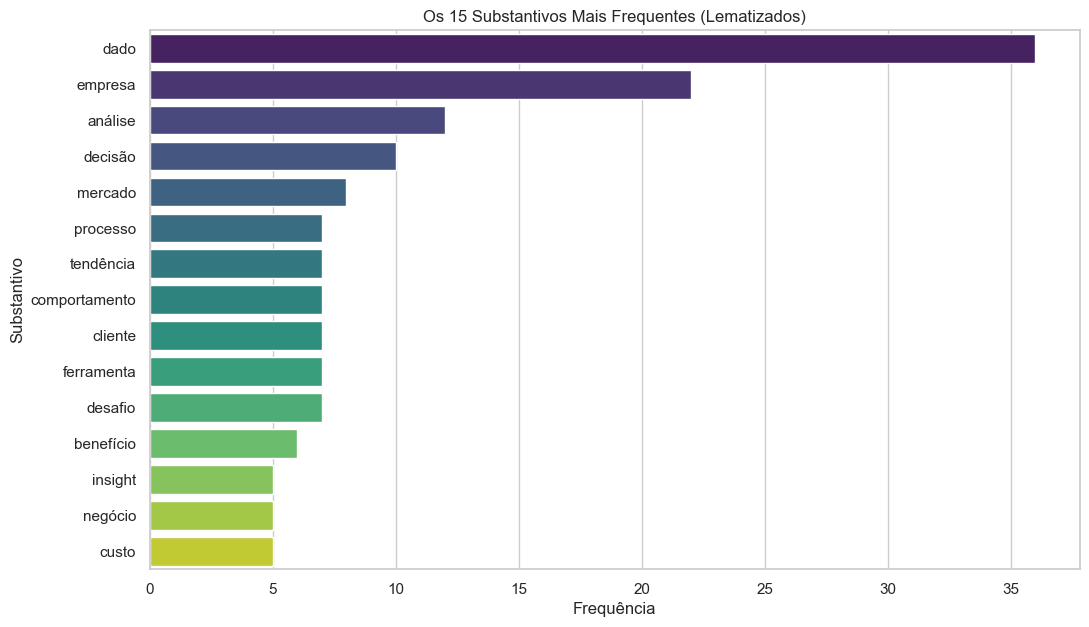

In [14]:
# 1.b) Frequência dos substantivos

# Juntar todos os tokens de todos os documentos
all_tokens = [token for doc in df['spacy_doc'] for token in doc]

# Filtrar por substantivos (NOUN), lematizar, converter para minúsculas e remover stopwords/pontuação
nouns = [
    token.lemma_.lower() 
    for token in all_tokens 
    if token.pos_ == 'NOUN' and not token.is_stop and not token.is_punct
]

# Contar a frequência
noun_freq = Counter(nouns)
common_nouns_df = pd.DataFrame(noun_freq.most_common(15), columns=['substantivo', 'frequencia'])

# Gerar o gráfico
plt.figure(figsize=(12, 7))
sns.barplot(data=common_nouns_df, x='frequencia', y='substantivo', palette='viridis')
plt.title('Os 15 Substantivos Mais Frequentes (Lematizados)')
plt.xlabel('Frequência')
plt.ylabel('Substantivo')
plt.show()

### 1.c) Apresente um gráfico de frequência dos adjetivos que mais ocorrem

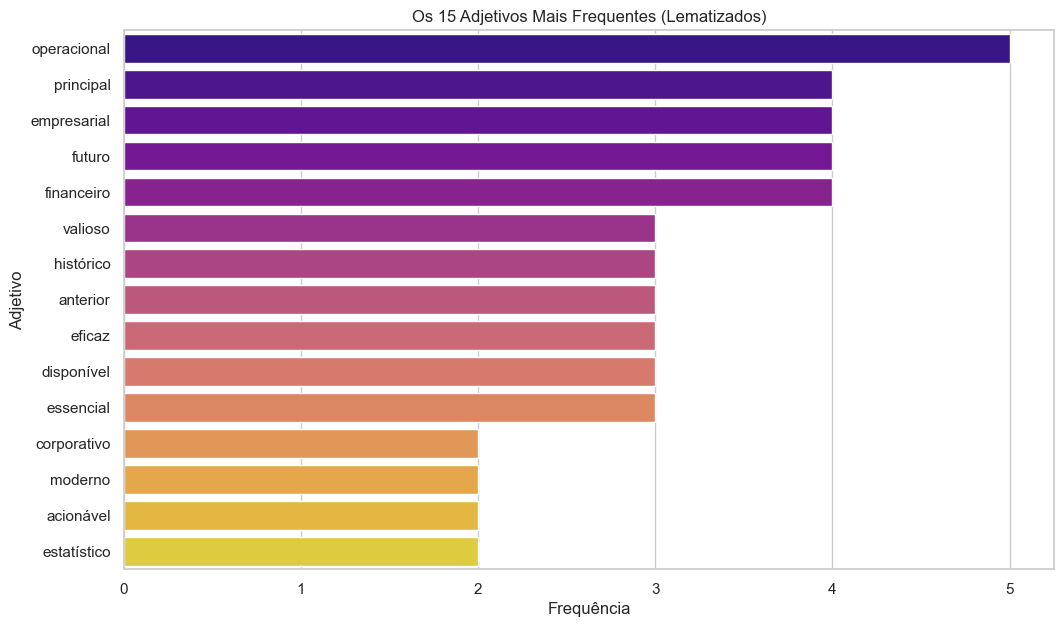

In [15]:
# 1.c) Frequência dos adjetivos

# Filtrar por adjetivos (ADJ), lematizar, converter para minúsculas e remover stopwords/pontuação
adjectives = [
    token.lemma_.lower() 
    for token in all_tokens 
    if token.pos_ == 'ADJ' and not token.is_stop and not token.is_punct
]

# Contar a frequência
adj_freq = Counter(adjectives)
common_adjs_df = pd.DataFrame(adj_freq.most_common(15), columns=['adjetivo', 'frequencia'])

# Gerar o gráfico
if not common_adjs_df.empty:
    plt.figure(figsize=(12, 7))
    sns.barplot(data=common_adjs_df, x='frequencia', y='adjetivo', palette='plasma')
    plt.title('Os 15 Adjetivos Mais Frequentes (Lematizados)')
    plt.xlabel('Frequência')
    plt.ylabel('Adjetivo')
    plt.show()
else:
    print("Nenhum adjetivo (após filtragem) encontrado para exibir no gráfico.")

### 1.d) Utilize o método RAKE (Rapid Automatic Keyword Extraction) e apresente um gráfico de frequência das palavras-chave mais frequentes

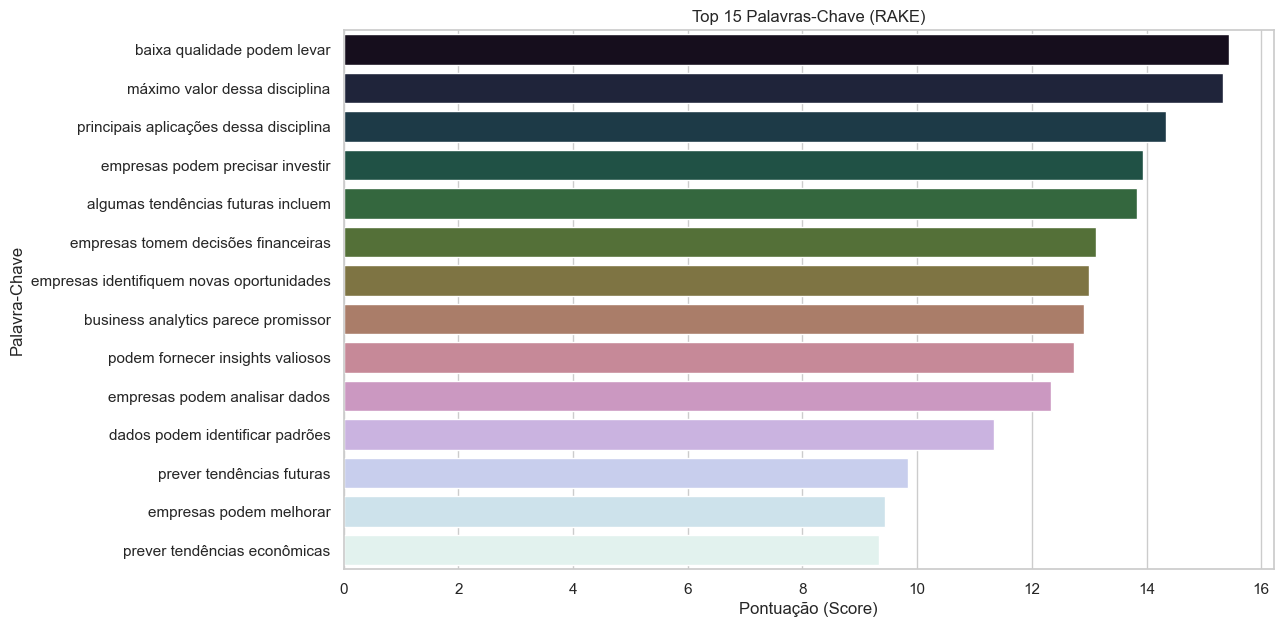

In [16]:
# 1.d) Metodo RAKE

# Configurar o RAKE com stopwords em português
portuguese_stopwords = stopwords.words('portuguese')
r = Rake(language='portuguese', stopwords=portuguese_stopwords, min_length=2, max_length=4)

# Combinar todo o texto em uma unica string
full_text = ' '.join(df['texto'])

# Extrair palavras-chave
r.extract_keywords_from_text(full_text)
keywords_with_scores = r.get_ranked_phrases_with_scores()

# Criar DataFrame com os resultados
keywords_df = pd.DataFrame(keywords_with_scores, columns=['score', 'palavra_chave'])

# Exibir o gráfico das 15 principais
top_keywords = keywords_df.head(15)

plt.figure(figsize=(12, 7))
sns.barplot(data=top_keywords, x='score', y='palavra_chave', palette='cubehelix')
plt.title('Top 15 Palavras-Chave (RAKE)')
plt.xlabel('Pontuação (Score)')
plt.ylabel('Palavra-Chave')
plt.show()

### 1.e) Considere coocorrências entre os seguintes UPOS: "ADJ","NOUN","PROPN","VERB". Apresente uma rede com as 100 coocorrências mais frequentes.

Rede de Coocorrência (Top 100 Pares)
Nós: 79, Arestas: 100


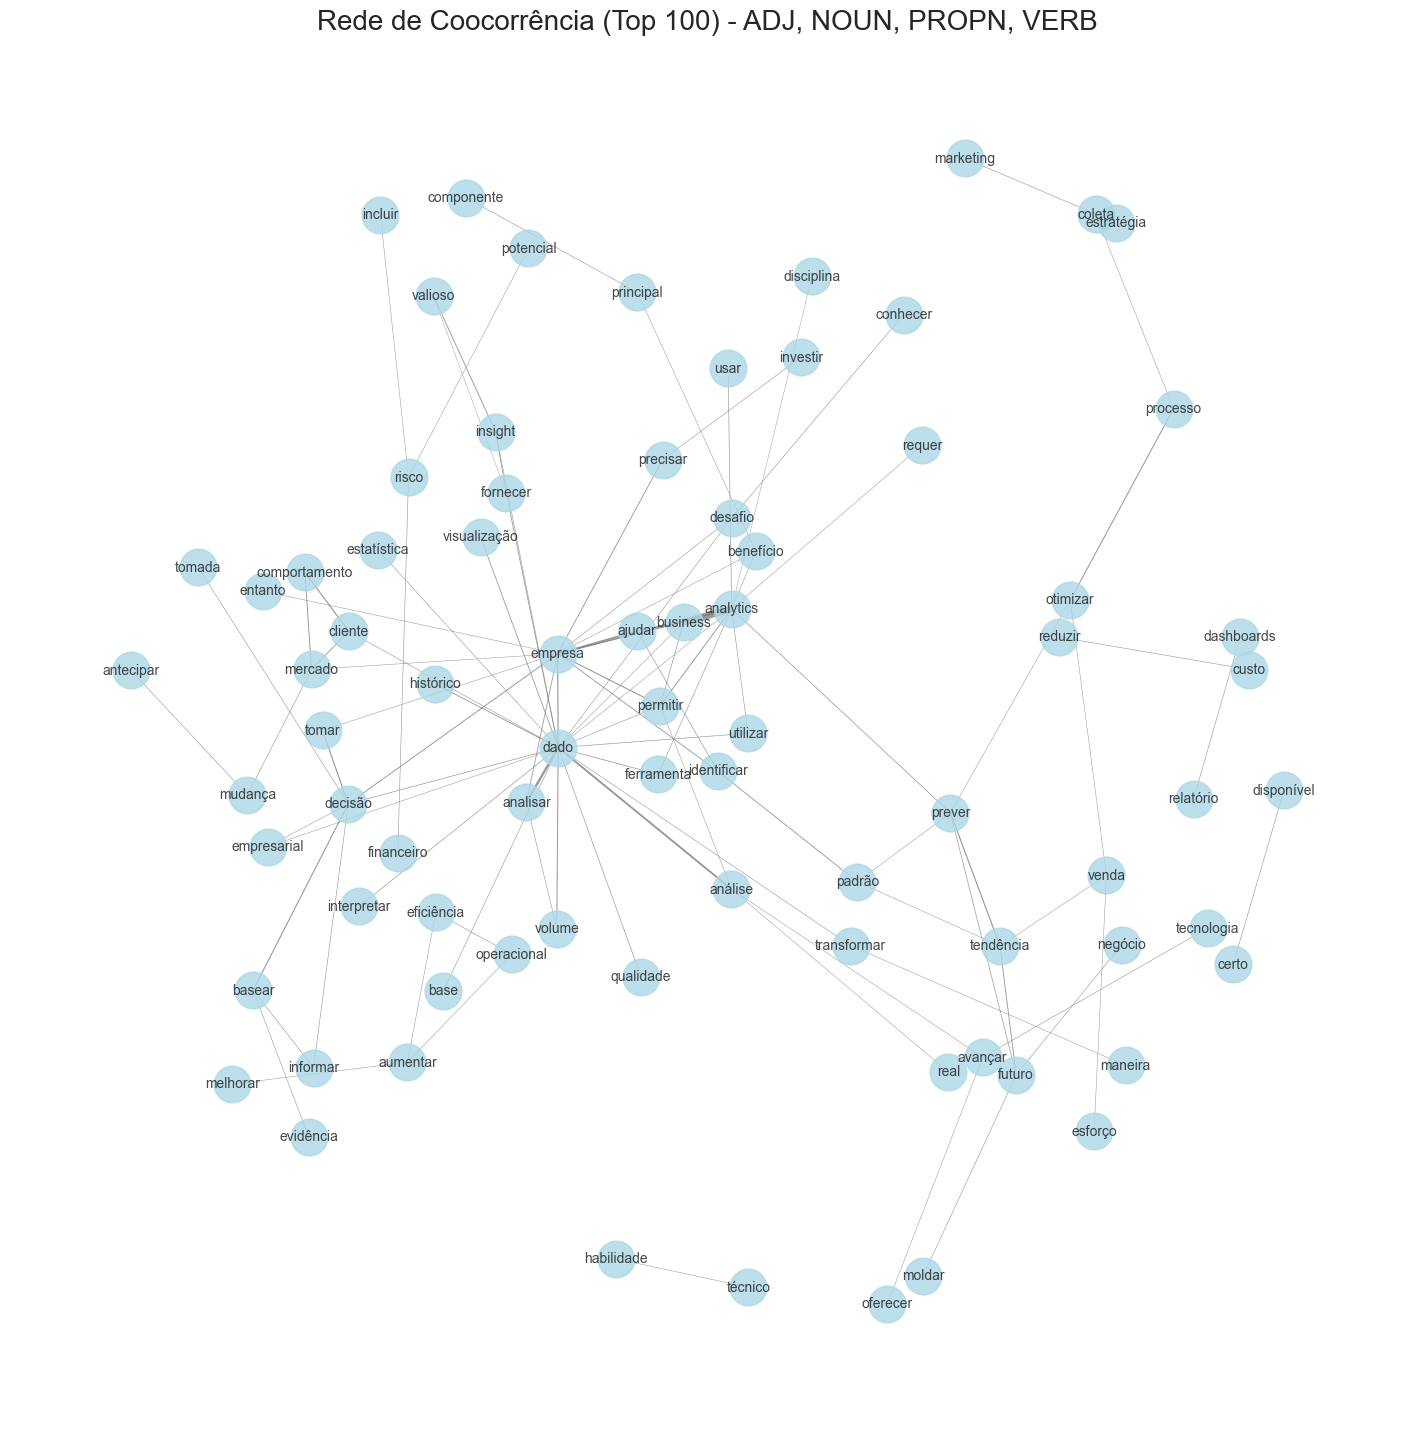

In [17]:
# 1.e) Rede de Coocorrências

target_upos = {"ADJ", "NOUN", "PROPN", "VERB"}
co_occurrences = Counter()
window_size = 5 # Janela de 5 palavras

for doc in df['spacy_doc']:
    # Filtrar tokens por UPOS, remover stopwords e pontuação, lematizar
    doc_tokens = [
        token.lemma_.lower() 
        for token in doc 
        if token.pos_ in target_upos and not token.is_stop and not token.is_punct
    ]
    
    # Gerar combinações dentro da janela deslizante
    for i in range(len(doc_tokens)):
        start = i
        end = min(i + window_size, len(doc_tokens))
        window_tokens = doc_tokens[start:end]
        
        # Criar pares de todas as combinações na janela
        for pair in combinations(window_tokens, 2):
            # Ordenar o par para evitar duplicatas (ex: (a,b) e (b,a))
            sorted_pair = tuple(sorted(pair))
            co_occurrences[sorted_pair] += 1

# Pegar as 100 coocorrências mais frequentes
top_100_cooc = co_occurrences.most_common(100)

# Criar o gráfico (rede) com NetworkX
G = nx.Graph()
for (node1, node2), weight in top_100_cooc:
    G.add_edge(node1, node2, weight=weight)

print(f"Rede de Coocorrência (Top 100 Pares)")
print(f"Nós: {G.number_of_nodes()}, Arestas: {G.number_of_edges()}")

# Desenhar a rede
plt.figure(figsize=(18, 18))
# Usar um layout que espalha os nós
pos = nx.spring_layout(G, k=0.7, iterations=40, seed=42)

# Ponderar a largura das arestas pela frequência
weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(weights)
scaled_weights = [5 * (w / max_weight) for w in weights]

nx.draw_networkx(
    G, 
    pos, 
    with_labels=True, 
    node_size=700, 
    node_color='lightblue', 
    font_size=10, 
    width=scaled_weights, 
    edge_color='grey', 
    alpha=0.8
)
plt.title('Rede de Coocorrência (Top 100) - ADJ, NOUN, PROPN, VERB', fontsize=20)
plt.axis('off')
plt.show()

## Questão 2

### 2.a) Considere 3 tópicos e apresente a matriz de documentos por tópicos, ou seja, três colunas e a distribuição de tópicos em cada "documento".

In [18]:
# 2.a) Modelagem de Tópicos (LDA) - Matriz Documentos x Tópicos

# Função de pré-processamento específica para LDA (lematizar, remover stopwords, focar em palavras relevantes)
def preprocess_lda(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower() 
        for token in doc 
        if token.pos_ in ['NOUN', 'ADJ', 'VERB'] 
        and not token.is_stop 
        and not token.is_punct 
        and len(token.lemma_) > 3
    ]
    return ' '.join(tokens)

# Aplicar pré-processamento
df['lda_text'] = df['texto'].apply(preprocess_lda)

# Criar a Matriz de Termos de Documentos (DTM)
# max_df=0.9: ignora palavras que aparecem em mais de 90% dos docs
# min_df=2: ignora palavras que aparecem em menos de 2 docs
vectorizer = CountVectorizer(max_df=0.9, min_df=2)
dtm = vectorizer.fit_transform(df['lda_text'])

# Treinar o modelo LDA
num_topics = 3
lda_model = LatentDirichletAllocation(
    n_components=num_topics, 
    random_state=42, 
    learning_method='batch'
)
lda_model.fit(dtm)

doc_topic_matrix = lda_model.transform(dtm)

# Criar um DataFrame para visualização clara
topic_columns = [f'Topico_{i+1}' for i in range(num_topics)]
doc_topic_df = pd.DataFrame(doc_topic_matrix, columns=topic_columns)
doc_topic_df.index.name = 'Documento_ID'

print("Matriz de Distribuição de Tópicos por Documento:")

print(doc_topic_df.to_string())

Matriz de Distribuição de Tópicos por Documento:
              Topico_1  Topico_2  Topico_3
Documento_ID                              
0             0.011282  0.977557  0.011161
1             0.333333  0.333333  0.333333
2             0.976795  0.010975  0.012229
3             0.166925  0.665836  0.167239
4             0.055541  0.738295  0.206164
5             0.960147  0.019406  0.020448
6             0.021980  0.020839  0.957181
7             0.859344  0.068698  0.071958
8             0.333333  0.333333  0.333333
9             0.030528  0.939604  0.029869
10            0.173221  0.167104  0.659675
11            0.952168  0.025258  0.022574
12            0.333333  0.333333  0.333333
13            0.026388  0.949200  0.024412
14            0.333333  0.333333  0.333333
15            0.942403  0.030325  0.027272
16            0.333333  0.333333  0.333333
17            0.031904  0.032566  0.935530
18            0.333333  0.333333  0.333333
19            0.918053  0.035364  0.046583
20   

### 2.b) Apresente um gráfico do app LDAvis com o tópico 1 selecionado

In [20]:
# 2.b) Gráfico LDAvis

# Preparar os dados para o pyLDAvis
# Usamos as variáveis lda_model, dtm, e vectorizer da célula anterior
vis_data = pyLDAvis.lda_model.prepare(lda_model, dtm, vectorizer, mds='tsne')

print("Visualização Interativa LDAvis (será exibida abaixo).")
print("Instrução: Por favor, clique no círculo do 'Tópico 1' na visualização para selecioná-lo.")

pyLDAvis.save_html(vis_data, "lda_vis.html")
print("Arquivo salvo: lda_vis.html")


Visualização Interativa LDAvis (será exibida abaixo).
Instrução: Por favor, clique no círculo do 'Tópico 1' na visualização para selecioná-lo.
Arquivo salvo: lda_vis.html
